In [2]:
import pandas as pd


## Overall

- This script looks at the whole blood data for Alzheimers and Parkinson's patients

- Read in data for each group for the top 100 cpg sites given by XGBoost
- Run the whole blood XGBoost model on this

In [1]:
import csv
import pandas as pd

data_location = 'disease_methylation.txt'
df = pd.read_csv(data_location, sep='\t',nrows=5,index_col=0)
df

,GSM1068826,GSM1068827,GSM1068829,GSM1068832,GSM1068833,GSM1068834,GSM1068835,GSM1068838,GSM1068839,GSM1068840,...,GSM1655185,GSM1344570,GSM1344687,GSM2125509,GSM2334025,GSM2190544.1,GSM1871195,GSM990041.1,GSM1506396,GSM1886655
sample_id,,,,,,,,,,,,,,,,,,,,,
disease,Alzheimer's disease,Alzheimer's disease,Alzheimer's disease,Alzheimer's disease,Alzheimer's disease,Alzheimer's disease,Alzheimer's disease,Alzheimer's disease,Alzheimer's disease,Alzheimer's disease,...,Ulcerative colitis,Ulcerative colitis,Ulcerative colitis,Ulcerative colitis,Ulcerative colitis,Ulcerative colitis,Ulcerative colitis,Ulcerative colitis,Ulcerative colitis,Ulcerative colitis
tissue,brain - cerebellum,brain - cerebellum,brain - cerebellum,brain - cerebellum,brain - cerebellum,brain - cerebellum,brain - cerebellum,brain - cerebellum,brain - cerebellum,brain - cerebellum,...,whole blood,whole blood,whole blood,whole blood,whole blood,whole blood,whole blood,whole blood,whole blood,whole blood
sample_type,case,case,case,case,case,case,case,case,case,case,...,control,control,control,control,control,control,control,control,control,control
cg00050873,NaN,NaN,NaN,NaN,0.819,0.757,0.806,NaN,0.814,0.814,...,NaN,NaN,0.835,0.822,NaN,NaN,0.851,0.881,NaN,NaN
cg00212031,NaN,NaN,NaN,NaN,0.009,0.011,0,NaN,0.026,0.018,...,NaN,NaN,0.02,0.048,NaN,NaN,0.043,0.025,NaN,NaN


In [2]:
unhealthy_meta=df.T
unhealthy_meta

sample_id,disease,tissue,sample_type,cg00050873,cg00212031
GSM1068826,Alzheimer's disease,brain - cerebellum,case,NaN,NaN
GSM1068827,Alzheimer's disease,brain - cerebellum,case,NaN,NaN
GSM1068829,Alzheimer's disease,brain - cerebellum,case,NaN,NaN
GSM1068832,Alzheimer's disease,brain - cerebellum,case,NaN,NaN
GSM1068833,Alzheimer's disease,brain - cerebellum,case,0.819,0.009
...,...,...,...,...,...
GSM2190544.1,Ulcerative colitis,whole blood,control,NaN,NaN
GSM1871195,Ulcerative colitis,whole blood,control,0.851,0.043
GSM990041.1,Ulcerative colitis,whole blood,control,0.881,0.025
GSM1506396,Ulcerative colitis,whole blood,control,NaN,NaN


In [3]:
unhealthy_ids=unhealthy_meta.index.tolist()

In [4]:
unhealthy_ids=unhealthy_ids[1:]
unhealthy_meta[:]['disease'].value_counts()



Alzheimer's disease                                 1809
schizophrenia                                       1362
systemic lupus erythematosus                        1052
rheumatoid arthritis                                 842
Ulcerative colitis                                   822
Parkinson's disease                                  738
preeclampsia                                         692
Crohn's disease                                      624
respiratory allergy                                  549
asthma                                               509
childhood asthma                                     495
multiple sclerosis                                   447
Down syndrome                                        436
Graves' disease                                      417
Huntington's disease                                 406
intellectual disability and congenital anomalies     400
systemic insulin resistance                          395
stroke                         

In [5]:
count_series = unhealthy_meta.groupby(['disease', 'tissue']).size()

In [6]:
print(count_series)

disease                       tissue                           
Alzheimer's disease           brain - cerebellum                   274
                              brain - entorhinal cortex            191
                              brain - frontal cortex               125
                              brain - frontal lobe                 201
                              brain - hippocampus                   54
                                                                  ... 
systemic lupus erythematosus  CD45RO-RA+ naive T cell               42
                              naive CD4+ T cell                    143
systemic sclerosis            peripheral blood mononuclear cell    198
type 2 diabetes               vastus lateralis muscle               48
                              whole blood                          258
Length: 84, dtype: int64


In [7]:
print(count_series.to_string())

disease                                           tissue                                
Alzheimer's disease                               brain - cerebellum                        274
                                                  brain - entorhinal cortex                 191
                                                  brain - frontal cortex                    125
                                                  brain - frontal lobe                      201
                                                  brain - hippocampus                        54
                                                  brain - occipital lobe                     64
                                                  brain - prefrontal cortex                 120
                                                  brain - superior temporal gyrus           326
                                                  brain - temporal lobe                     155
                                               

# Extracting useful data

In [8]:
#Column values for relevant data
id_alzheimers_blood=[]
id_parkinsons_blood=[]

for i in unhealthy_ids:
    if unhealthy_meta.loc[i]['disease']=="Alzheimer's disease" and unhealthy_meta.loc[i]['tissue']=="whole blood":
        id_alzheimers_blood.append(i)
        
    if unhealthy_meta.loc[i]['disease']=="Parkinson's disease" and unhealthy_meta.loc[i]['tissue']=="whole blood":
        id_parkinsons_blood.append(i)
        
    
    

In [9]:
id_alzheimers_blood

['GSM1069225',
 'GSM1069226',
 'GSM1069227',
 'GSM1069228',
 'GSM1069229',
 'GSM1069232',
 'GSM1069235',
 'GSM1069239',
 'GSM1069240',
 'GSM1069243',
 'GSM1069244',
 'GSM1069245',
 'GSM1069246',
 'GSM1069247',
 'GSM1069249',
 'GSM1069251',
 'GSM1069252',
 'GSM1069254',
 'GSM1069256',
 'GSM1069257',
 'GSM1069261',
 'GSM1069262',
 'GSM1069263',
 'GSM1069264',
 'GSM1069265',
 'GSM1069267',
 'GSM1069269',
 'GSM1069270',
 'GSM1069276',
 'GSM1069277',
 'GSM1069278',
 'GSM1069280',
 'GSM1069282',
 'GSM1069284',
 'GSM1069286',
 'GSM1069289',
 'GSM1069290',
 'GSM1069293',
 'GSM1069294',
 'GSM1069308',
 'GSM1069309',
 'GSM1069310',
 'GSM1069311',
 'GSM1069312',
 'GSM1069314',
 'GSM1069316',
 'GSM1069317',
 'GSM1069318',
 'GSM1300342',
 'GSM1300354',
 'GSM1300366',
 'GSM1300378',
 'GSM1300390',
 'GSM1300402',
 'GSM1300414',
 'GSM1300426',
 'GSM1300493',
 'GSM1300499',
 'GSM1300500',
 'GSM1300524',
 'GSM1300538',
 'GSM1300550',
 'GSM1300556',
 'GSM1443284',
 'GSM1443290',
 'GSM1443294',
 'GSM14433

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import seaborn as sns
import _pickle as cPickle

with open(r"cpgs_XGboost_whole_blood_ranked", "rb") as input_file:
    cpg_xgb = cPickle.load(input_file)
    
cpg_xgb=cpg_xgb[:100]

In [72]:
len(cpg_xgb)

100

In [73]:
allcpgs = []
with open(r'disease_methylation.txt') as f:
    for row in f:
        allcpgs.append(row[0:10])

In [60]:
# we want to skip the rows that are not in cpg_xgb
skipped = []
for i in range(4,len(allcpgs)):
    if allcpgs[i] not in cpg_xgb:
        skipped.append(i)

# Alzheimer's whole blood - XGBoost top

In [61]:
#
col=['sample_id']+id_alzheimers_blood
skp=[1,2,3]+skipped
alz_bld_top100_xboost = pd.read_csv('disease_methylation.txt', delimiter = '\t', skiprows=skp, usecols=col, low_memory=False)
alz_bld_top100_xboost=alz_bld_top100_xboost.set_index('sample_id')

alz_bld_top100_xboost


,GSM1069225,GSM1069226,GSM1069227,GSM1069228,GSM1069229,GSM1069232,GSM1069235,GSM1069239,GSM1069240,GSM1069243,...,GSM990062,GSM3035460,GSM3035824,GSM1871051,GSM1870556,GSM1870611,GSM3035793,GSM1870291,GSM1299778,GSM990589
sample_id,,,,,,,,,,,,,,,,,,,,,
cg01074797,0.525,0.582,0.558,0.583,0.519,0.450,0.590,0.504,0.547,0.391,...,0.626,0.699,0.610,0.442,0.465,0.519,0.465,0.519,0.398,0.445
cg06784991,0.406,0.336,0.310,0.378,0.270,0.252,0.359,0.306,0.307,0.306,...,0.326,0.290,0.324,0.261,0.299,0.259,0.299,0.259,0.262,0.304
cg07181952,0.617,0.612,0.635,0.678,0.540,0.623,0.656,0.658,0.652,0.705,...,0.654,0.662,0.719,0.592,0.590,0.610,0.590,0.610,0.671,0.637
cg07418114,0.632,0.693,0.694,0.681,0.596,0.668,0.747,0.729,0.673,0.595,...,0.640,0.688,0.678,0.596,0.670,0.684,0.670,0.684,0.668,0.649
cg22454769,0.655,0.705,0.639,0.684,0.667,0.560,0.622,0.694,0.706,0.898,...,0.690,0.534,0.609,0.378,0.701,0.552,0.701,0.552,0.607,0.657
cg23606718,0.226,0.220,0.232,0.356,0.179,0.182,0.284,0.219,0.245,0.238,...,0.276,0.185,0.226,0.148,0.196,0.219,0.196,0.219,0.221,0.182
cg24079702,0.449,0.496,0.451,0.479,0.472,0.386,0.452,0.497,0.490,0.772,...,0.505,0.327,0.390,0.241,0.440,0.347,0.440,0.347,0.473,0.462
cg07553761,0.391,0.367,0.329,0.343,0.392,0.337,0.304,0.376,0.402,0.487,...,0.322,0.172,0.273,0.344,0.350,0.311,0.350,0.311,0.383,0.431
cg12252865,0.787,0.692,0.740,0.822,0.650,0.719,0.743,0.733,0.767,0.702,...,0.690,0.705,0.744,0.614,0.696,0.762,0.696,0.762,0.704,0.726


# Parkinsons whole blood - XGBoost top

In [17]:
col=['sample_id']+id_parkinsons_blood
skp=[1,2,3]+skipped
park_bld_top100_xboost = pd.read_csv('disease_methylation.txt', delimiter = '\t', skiprows=skp, usecols=col, low_memory=False)


In [19]:
park_bld_top100_xboost=park_bld_top100_xboost.set_index('sample_id')
park_bld_top100_xboost

,GSM3035963,GSM3035809,GSM3035847,GSM1870906,GSM1871363,GSM3035565,GSM3035588,GSM1871339,GSM3035499,GSM1870491,...,GSM1871041,GSM2250409,GSM1466011,GSM1344809,GSM1343991,GSM1506296,GSM1871002.1,GSM1870956,GSM1871053,GSM1870775
sample_id,,,,,,,,,,,,,,,,,,,,,
cg01074797,0.528,0.581,0.532,0.555,0.640,0.611,0.637,0.510,0.672,0.408,...,0.512,0.511,0.645,0.624,0.322,0.572,0.624,0.619,0.636,0.661
cg06784991,0.274,0.333,0.242,0.321,0.334,0.296,0.280,0.319,0.288,0.226,...,0.323,0.259,0.295,0.280,0.290,0.340,0.290,0.296,0.323,0.309
cg07181952,0.624,0.696,0.673,0.665,0.626,0.649,0.685,0.610,0.652,0.716,...,0.679,0.645,0.691,0.640,0.698,0.659,0.665,0.642,0.669,0.638
cg07418114,0.685,0.643,0.639,0.627,0.664,0.667,0.654,0.624,0.599,0.688,...,0.723,0.706,0.669,0.646,0.639,0.656,0.697,0.651,0.648,0.673
cg22454769,0.702,0.606,0.512,0.717,0.692,0.644,0.754,0.598,0.640,0.473,...,0.618,0.528,0.563,0.658,0.615,0.644,0.610,0.601,0.492,0.623
cg23606718,0.149,0.154,0.195,0.206,0.177,0.207,0.202,0.165,0.173,0.100,...,0.160,0.152,0.235,0.234,0.211,0.224,0.188,0.259,0.153,0.180
cg24079702,0.545,0.377,0.303,0.485,0.494,0.420,0.569,0.357,0.404,0.261,...,0.467,0.324,0.392,0.394,0.399,0.482,0.397,0.421,0.342,0.453
cg07553761,0.354,0.309,0.380,0.345,0.347,0.297,0.338,0.366,0.241,0.250,...,0.352,0.280,0.267,0.285,0.264,0.294,0.283,0.402,0.313,0.394
cg12252865,0.685,0.676,0.642,0.729,0.725,0.746,0.705,0.696,0.682,0.750,...,0.766,0.779,0.716,0.819,0.795,0.729,0.754,0.750,0.639,0.682


# Extracting subsection of wholeblood with same CpG's

In [40]:
park_bld_top100_xboost

sample_id,AGE,cg01074797,cg06784991,cg07181952,cg07418114,cg22454769,cg23606718,cg24079702,cg07553761,cg12252865,...,cg18343474,cg18933331,cg23078123,cg25256723,cg25410668,cg06639320,cg00329615,cg03607117,cg16932827,cg26614073
GSM3035963,78.0,0.528,0.274,0.624,0.685,0.702,0.149,0.545,0.354,0.685,...,0.089,0.269,0.443,0.722,0.948,0.589,0.322,0.086,0.772,0.394
GSM3035809,78.0,0.581,0.333,0.696,0.643,0.606,0.154,0.377,0.309,0.676,...,0.202,0.359,0.556,0.713,0.744,0.532,0.439,0.088,0.775,0.372
GSM3035847,75.0,0.532,0.242,0.673,0.639,0.512,0.195,0.303,0.380,0.642,...,0.189,0.375,0.542,0.619,0.733,0.455,0.346,0.043,0.661,0.435
GSM1870906,71.4,0.555,0.321,0.665,0.627,0.717,0.206,0.485,0.345,0.729,...,0.194,0.344,0.591,0.638,0.917,0.576,0.250,0.081,0.661,0.417
GSM1871363,76.2,0.640,0.334,0.626,0.664,0.692,0.177,0.494,0.347,0.725,...,0.159,0.539,0.589,0.784,0.723,0.617,0.405,0.139,0.840,0.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1506296,68.0,0.572,0.340,0.659,0.656,0.644,0.224,0.482,0.294,0.729,...,0.136,0.400,0.491,0.619,0.698,0.505,0.354,0.075,0.821,0.426
GSM1871002.1,62.5,0.624,0.290,0.665,0.697,0.610,0.188,0.397,0.283,0.754,...,0.122,0.484,0.581,0.784,0.704,0.534,0.469,0.062,0.827,0.492
GSM1870956,69.7,0.619,0.296,0.642,0.651,0.601,0.259,0.421,0.402,0.750,...,0.150,0.380,0.456,0.652,0.648,0.590,0.371,0.078,0.701,0.512
GSM1871053,64.5,0.636,0.323,0.669,0.648,0.492,0.153,0.342,0.313,0.639,...,0.140,0.429,0.656,0.653,0.728,0.479,0.392,0.037,0.846,0.539


In [91]:
allcpgs_unhealthy = []
with open(r'disease_methylation.txt') as f:
    for row in f:
        allcpgs_unhealthy.append(row[0:10])

In [99]:
len(allcpgs_unhealthy)


225197

In [101]:
allcpgs_hc = []
with open(r'blood_methylation_v1.txt') as f:
    for row in f:
        allcpgs_hc.append(row[0:10])

In [102]:
len(allcpgs_hc)


399353

In [92]:
with open(r"cpgs_XGboost_whole_blood_ranked", "rb") as input_file:
    cpg_xgb = cPickle.load(input_file)
    
cpg_xgb=cpg_xgb[:100]

In [142]:
with open(r"cpgs_XGboost_brain_ranked", "rb") as input_file:
    cpg_xgb_brain = cPickle.load(input_file)
    
cpg_xgb_brain=cpg_xgb_brain[:100]

In [138]:
shared=[]
for i in cpg_xgb:
    if i in allcpgs_unhealthy:
        shared.append(i)
     

In [143]:
shared_brain=[]
for i in cpg_xgb_brain:
    if i in allcpgs_unhealthy:
        shared_brain.append(i)
len(shared_brain)

55

In [145]:
len(shared)

56

In [144]:
len(shared)
with open("brain_shared_healthy_unhealthy.txt", "w") as output:
    output.write(str(shared_brain))

In [154]:
with open('brain_shared_healthy_unhealthy', 'wb') as fp:
    cPickle.dump(shared_brain, fp)

In [146]:
with open('whole_blood_shared_healthy_unhealthy', 'wb') as fp:
    cPickle.dump(shared, fp)

In [103]:
miss=[]
for i in cpg_xgb:
    if i not in allcpgs_hc:
        miss.append(i)
        

In [90]:
with open("missing.txt", "w") as output:
    output.write(str(miss))

In [105]:
# in unhealthy but not in healthy
conf=[]
for i in miss:
    if i in allcpgs_unhealthy:
        conf.append(i)

In [111]:
shared_w_unhealthy=list(alz_bld_top100_xboost.T.columns)

allcpgs_hc = []
with open(r'blood_methylation_v1.txt') as f:
    for row in f:
        allcpgs_hc.append(row[0:10])

In [120]:
# we want to skip the rows of CpG sites that are not shared w. unhealthy patients
# i.e. not in shared_w_unhealthy
skipped_HC = []
for i in range(2,len(allcpgs_hc)):
    if allcpgs_hc[i] not in shared_w_unhealthy:
        skipped_HC.append(i)

In [121]:
skp=skipped_HC
wb_hc_56 = pd.read_csv('blood_methylation_v1.txt', delimiter = '\t', skiprows=skp,low_memory=False)
wb_hc_56=wb_hc_56.set_index('sample_id')

wb_hc_56

,GSM1326049,GSM1343182,GSM1344232,GSM1326088,GSM1466102,GSM2814503,GSM1886461,GSM2810378,GSM2187376,GSM2337055,...,GSM977390,GSM977391,GSM977392,GSM977393,GSM977394,GSM977395,GSM977396,GSM977397,GSM977398,GSM977399
sample_id,,,,,,,,,,,,,,,,,,,,,
tissue,whole blood,whole blood,whole blood,whole blood,whole blood,whole blood,whole blood,whole blood,whole blood,whole blood,...,lymphoblastoid cell line,lymphoblastoid cell line,lymphoblastoid cell line,lymphoblastoid cell line,lymphoblastoid cell line,lymphoblastoid cell line,lymphoblastoid cell line,lymphoblastoid cell line,lymphoblastoid cell line,lymphoblastoid cell line
cg01074797,0.534,0.576,0.631,0.684,0.664,0.49,0.703,0.724,0.828,0.828,...,0.349,0.055,0.317,0.364,0.355,0.395,0.376,0.393,0.321,0.045
cg06784991,0.274,0.28,0.235,0.327,0.301,0.219,0.233,0.279,0.22,0.229,...,0.189,0.169,0.312,0.195,0.249,0.204,0.375,0.203,0.264,0.249
cg07181952,0.63,0.715,0.664,0.699,0.649,0.772,0.668,0.683,0.782,0.768,...,0.399,0.199,0.599,0.538,0.449,0.566,0.502,0.509,0.542,0.428
cg07418114,0.67,0.729,0.691,0.714,0.685,0.738,0.698,0.748,0.693,0.754,...,0.432,0.526,0.474,0.445,0.326,0.497,0.509,0.295,0.468,0.476
cg22454769,0.73,0.699,0.632,0.698,0.589,0.329,0.321,0.466,0.186,0.298,...,0.867,0.581,0.772,0.614,0.834,0.636,0.649,0.73,0.976,0.987
cg23606718,0.131,0.26,0.15,0.128,0.173,0.073,0.12,0.109,0.05,0.073,...,0.099,0.4,0.24,0.14,0.133,0.36,0.157,0.151,0.158,0.204
cg24079702,0.457,0.488,0.429,0.454,0.413,0.213,0.178,0.273,0.126,0.184,...,NaN,0.127,0.386,0.224,0.625,0.327,0.29,0.321,0.91,0.96
cg07553761,0.287,0.381,0.32,0.31,0.253,0.17,0.166,0.219,0.13,0.141,...,0.238,0.661,0.22,0.319,0.267,0.181,0.311,0.301,0.283,0.253


In [147]:
#wb_hc_56=wb_hc_56.T
wb_hc_56

sample_id,tissue,cg01074797,cg06784991,cg07181952,cg07418114,cg22454769,cg23606718,cg24079702,cg07553761,cg12252865,...,cg18343474,cg18933331,cg23078123,cg25256723,cg25410668,cg06639320,cg00329615,cg03607117,cg16932827,cg26614073
GSM1326049,whole blood,0.534,0.274,0.63,0.67,0.73,0.131,0.457,0.287,0.788,...,0.188,0.339,0.557,0.502,0.66,0.566,0.384,0.08,0.686,0.358
GSM1343182,whole blood,0.576,0.28,0.715,0.729,0.699,0.26,0.488,0.381,0.783,...,0.173,0.378,0.576,0.68,0.542,0.537,0.353,0.091,0.789,0.402
GSM1344232,whole blood,0.631,0.235,0.664,0.691,0.632,0.15,0.429,0.32,0.787,...,0.126,0.399,0.577,0.628,0.556,0.485,0.321,0.1,0.798,0.46
GSM1326088,whole blood,0.684,0.327,0.699,0.714,0.698,0.128,0.454,0.31,0.795,...,0.134,0.401,0.573,0.678,0.63,0.526,0.358,0.075,0.882,0.483
GSM1466102,whole blood,0.664,0.301,0.649,0.685,0.589,0.173,0.413,0.253,0.767,...,0.141,0.517,0.589,0.688,0.548,0.483,0.398,0.061,0.883,0.468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1506332,whole blood,0.568,0.238,0.632,0.713,0.595,0.124,0.409,0.31,0.773,...,0.108,0.427,0.603,0.629,0.622,0.499,0.382,0.07,0.793,0.516
GSM1300503,whole blood,0.583,0.332,0.634,0.851,0.592,0.26,0.462,0.244,0.841,...,0.14,0.44,0.576,0.81,0.704,0.558,NaN,0.042,0.941,0.47
GSM2738222,whole blood,0.675,0.207,0.718,0.692,0.323,0.068,0.186,0.162,0.826,...,0.108,0.599,0.838,0.828,0.577,0.32,NaN,0.042,0.919,0.417
GSM2250705,whole blood,0.495,0.299,0.675,0.692,0.492,0.168,0.272,0.269,0.728,...,0.156,0.445,0.635,0.746,0.671,0.46,0.38,0.081,0.824,0.563


In [150]:
hc_order=list(wb_hc_56.columns)[1:]


In [152]:
with open('whole_blood_shared_hc_order', 'wb') as fp:
    cPickle.dump(shared, fp)

In [136]:
ids=list(wb_hc_56.index.values)
for i in ids:
    if wb_hc_56.loc[i]['tissue']!='whole blood':
        wb_hc_56=wb_hc_56.drop([i])

In [137]:
wb_hc_56

sample_id,tissue,cg01074797,cg06784991,cg07181952,cg07418114,cg22454769,cg23606718,cg24079702,cg07553761,cg12252865,...,cg18343474,cg18933331,cg23078123,cg25256723,cg25410668,cg06639320,cg00329615,cg03607117,cg16932827,cg26614073
GSM1326049,whole blood,0.534,0.274,0.63,0.67,0.73,0.131,0.457,0.287,0.788,...,0.188,0.339,0.557,0.502,0.66,0.566,0.384,0.08,0.686,0.358
GSM1343182,whole blood,0.576,0.28,0.715,0.729,0.699,0.26,0.488,0.381,0.783,...,0.173,0.378,0.576,0.68,0.542,0.537,0.353,0.091,0.789,0.402
GSM1344232,whole blood,0.631,0.235,0.664,0.691,0.632,0.15,0.429,0.32,0.787,...,0.126,0.399,0.577,0.628,0.556,0.485,0.321,0.1,0.798,0.46
GSM1326088,whole blood,0.684,0.327,0.699,0.714,0.698,0.128,0.454,0.31,0.795,...,0.134,0.401,0.573,0.678,0.63,0.526,0.358,0.075,0.882,0.483
GSM1466102,whole blood,0.664,0.301,0.649,0.685,0.589,0.173,0.413,0.253,0.767,...,0.141,0.517,0.589,0.688,0.548,0.483,0.398,0.061,0.883,0.468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1506332,whole blood,0.568,0.238,0.632,0.713,0.595,0.124,0.409,0.31,0.773,...,0.108,0.427,0.603,0.629,0.622,0.499,0.382,0.07,0.793,0.516
GSM1300503,whole blood,0.583,0.332,0.634,0.851,0.592,0.26,0.462,0.244,0.841,...,0.14,0.44,0.576,0.81,0.704,0.558,NaN,0.042,0.941,0.47
GSM2738222,whole blood,0.675,0.207,0.718,0.692,0.323,0.068,0.186,0.162,0.826,...,0.108,0.599,0.838,0.828,0.577,0.32,NaN,0.042,0.919,0.417
GSM2250705,whole blood,0.495,0.299,0.675,0.692,0.492,0.168,0.272,0.269,0.728,...,0.156,0.445,0.635,0.746,0.671,0.46,0.38,0.081,0.824,0.563


In [69]:
hc=list(wb_hc_56.T.columns)[2:]
missed=[]
for i in hc:
    if i not in shared_w_unhealthy:
        missed.append(i)
        
missed

['cg00050873',
 'cg01074955',
 'cg06785712',
 'cg07183372',
 'cg07420190',
 'cg22470850',
 'cg23609528',
 'cg24083496',
 'cg07556134',
 'cg12252866',
 'cg01555352',
 'cg01256882',
 'cg26116742',
 'cg06555155',
 'cg08457790',
 'cg16869487',
 'cg24725574',
 'cg00294823',
 'cg07928105',
 'cg07956515',
 'cg22286616',
 'cg20532937',
 'cg02050593',
 'cg02933478',
 'cg05095158',
 'cg23100081',
 'cg23748172',
 'cg00776266',
 'cg03404362',
 'cg09696331',
 'cg04576764',
 'cg18882971',
 'cg04885935',
 'cg22454673',
 'cg04211501',
 'cg04506728',
 'cg06978336',
 'cg14697743',
 'cg20275462',
 'cg19345821',
 'cg22195627',
 'cg00535683',
 'cg03883491',
 'cg05308895']

# Getting ages

In [20]:
#meta = pd.read_csv('sample_disease.txt', delimiter = '\t')
meta = []

with open(r'sample_disease.txt') as f:
    for row in f:
        meta.append(row[0:50])
    
meta[1]

'"GSM1068826" "GSM1068826" 88 NA NA NA NA NA NA NA '

In [21]:
meta_2=[]
for i in meta:
    meta_2.append(i.split())

In [22]:
ages=[]
df_id_ages=[]
df_age=[]
for i in range(1,len(meta_2)):
    p=meta_2[i]
    v=[]
    v.append(p[0][1:-1])
    v.append(p[2])
    df_id_ages.append(p[0][1:-1])
    df_age.append(p[2])
    ages.append(v)
    

In [23]:
df_ages = pd.DataFrame({'id': df_id_ages,
                   'age': df_age,})

In [24]:
df_ages=df_ages.set_index('id')
df_ages

,age
id,
GSM1068826,88
GSM1068827,92
GSM1068829,93
GSM1068832,96
GSM1068833,86
...,...
GSM2190544.1,0
GSM1871195,74.4
GSM990041.1,69


In [25]:
type(df_ages.loc['GSM1068826']['age'])

str

# Adding age to Parkinson's

In [26]:
park_bld_top100_xboost=park_bld_top100_xboost.T
park_bld_top100_xboost['AGE']=np.zeros(len(id_parkinsons_blood))
park_bld_top100_xboost

sample_id,cg01074797,cg06784991,cg07181952,cg07418114,cg22454769,cg23606718,cg24079702,cg07553761,cg12252865,cg01552919,...,cg18933331,cg23078123,cg25256723,cg25410668,cg06639320,cg00329615,cg03607117,cg16932827,cg26614073,AGE
GSM3035963,0.528,0.274,0.624,0.685,0.702,0.149,0.545,0.354,0.685,0.800,...,0.269,0.443,0.722,0.948,0.589,0.322,0.086,0.772,0.394,0.0
GSM3035809,0.581,0.333,0.696,0.643,0.606,0.154,0.377,0.309,0.676,0.845,...,0.359,0.556,0.713,0.744,0.532,0.439,0.088,0.775,0.372,0.0
GSM3035847,0.532,0.242,0.673,0.639,0.512,0.195,0.303,0.380,0.642,0.813,...,0.375,0.542,0.619,0.733,0.455,0.346,0.043,0.661,0.435,0.0
GSM1870906,0.555,0.321,0.665,0.627,0.717,0.206,0.485,0.345,0.729,0.745,...,0.344,0.591,0.638,0.917,0.576,0.250,0.081,0.661,0.417,0.0
GSM1871363,0.640,0.334,0.626,0.664,0.692,0.177,0.494,0.347,0.725,0.846,...,0.539,0.589,0.784,0.723,0.617,0.405,0.139,0.840,0.500,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1506296,0.572,0.340,0.659,0.656,0.644,0.224,0.482,0.294,0.729,0.772,...,0.400,0.491,0.619,0.698,0.505,0.354,0.075,0.821,0.426,0.0
GSM1871002.1,0.624,0.290,0.665,0.697,0.610,0.188,0.397,0.283,0.754,0.845,...,0.484,0.581,0.784,0.704,0.534,0.469,0.062,0.827,0.492,0.0
GSM1870956,0.619,0.296,0.642,0.651,0.601,0.259,0.421,0.402,0.750,0.833,...,0.380,0.456,0.652,0.648,0.590,0.371,0.078,0.701,0.512,0.0
GSM1871053,0.636,0.323,0.669,0.648,0.492,0.153,0.342,0.313,0.639,0.878,...,0.429,0.656,0.653,0.728,0.479,0.392,0.037,0.846,0.539,0.0


In [28]:
cols = list(park_bld_top100_xboost.columns.values)
cols=cols[0:-1]
park_bld_top100_xboost = park_bld_top100_xboost[['AGE']+cols]
park_bld_top100_xboost


sample_id,AGE,cg01074797,cg06784991,cg07181952,cg07418114,cg22454769,cg23606718,cg24079702,cg07553761,cg12252865,...,cg18343474,cg18933331,cg23078123,cg25256723,cg25410668,cg06639320,cg00329615,cg03607117,cg16932827,cg26614073
GSM3035963,0.0,0.528,0.274,0.624,0.685,0.702,0.149,0.545,0.354,0.685,...,0.089,0.269,0.443,0.722,0.948,0.589,0.322,0.086,0.772,0.394
GSM3035809,0.0,0.581,0.333,0.696,0.643,0.606,0.154,0.377,0.309,0.676,...,0.202,0.359,0.556,0.713,0.744,0.532,0.439,0.088,0.775,0.372
GSM3035847,0.0,0.532,0.242,0.673,0.639,0.512,0.195,0.303,0.380,0.642,...,0.189,0.375,0.542,0.619,0.733,0.455,0.346,0.043,0.661,0.435
GSM1870906,0.0,0.555,0.321,0.665,0.627,0.717,0.206,0.485,0.345,0.729,...,0.194,0.344,0.591,0.638,0.917,0.576,0.250,0.081,0.661,0.417
GSM1871363,0.0,0.640,0.334,0.626,0.664,0.692,0.177,0.494,0.347,0.725,...,0.159,0.539,0.589,0.784,0.723,0.617,0.405,0.139,0.840,0.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1506296,0.0,0.572,0.340,0.659,0.656,0.644,0.224,0.482,0.294,0.729,...,0.136,0.400,0.491,0.619,0.698,0.505,0.354,0.075,0.821,0.426
GSM1871002.1,0.0,0.624,0.290,0.665,0.697,0.610,0.188,0.397,0.283,0.754,...,0.122,0.484,0.581,0.784,0.704,0.534,0.469,0.062,0.827,0.492
GSM1870956,0.0,0.619,0.296,0.642,0.651,0.601,0.259,0.421,0.402,0.750,...,0.150,0.380,0.456,0.652,0.648,0.590,0.371,0.078,0.701,0.512
GSM1871053,0.0,0.636,0.323,0.669,0.648,0.492,0.153,0.342,0.313,0.639,...,0.140,0.429,0.656,0.653,0.728,0.479,0.392,0.037,0.846,0.539


In [29]:
for i in id_parkinsons_blood:
    try:
        park_bld_top100_xboost.loc[i]['AGE']=float(df_ages.loc[i]['age'])
    except KeyError:
        park_bld_top100_xboost.loc[i]['AGE']='NaN'

In [30]:
park_bld_top100_xboost

sample_id,AGE,cg01074797,cg06784991,cg07181952,cg07418114,cg22454769,cg23606718,cg24079702,cg07553761,cg12252865,...,cg18343474,cg18933331,cg23078123,cg25256723,cg25410668,cg06639320,cg00329615,cg03607117,cg16932827,cg26614073
GSM3035963,78.0,0.528,0.274,0.624,0.685,0.702,0.149,0.545,0.354,0.685,...,0.089,0.269,0.443,0.722,0.948,0.589,0.322,0.086,0.772,0.394
GSM3035809,78.0,0.581,0.333,0.696,0.643,0.606,0.154,0.377,0.309,0.676,...,0.202,0.359,0.556,0.713,0.744,0.532,0.439,0.088,0.775,0.372
GSM3035847,75.0,0.532,0.242,0.673,0.639,0.512,0.195,0.303,0.380,0.642,...,0.189,0.375,0.542,0.619,0.733,0.455,0.346,0.043,0.661,0.435
GSM1870906,71.4,0.555,0.321,0.665,0.627,0.717,0.206,0.485,0.345,0.729,...,0.194,0.344,0.591,0.638,0.917,0.576,0.250,0.081,0.661,0.417
GSM1871363,76.2,0.640,0.334,0.626,0.664,0.692,0.177,0.494,0.347,0.725,...,0.159,0.539,0.589,0.784,0.723,0.617,0.405,0.139,0.840,0.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1506296,68.0,0.572,0.340,0.659,0.656,0.644,0.224,0.482,0.294,0.729,...,0.136,0.400,0.491,0.619,0.698,0.505,0.354,0.075,0.821,0.426
GSM1871002.1,62.5,0.624,0.290,0.665,0.697,0.610,0.188,0.397,0.283,0.754,...,0.122,0.484,0.581,0.784,0.704,0.534,0.469,0.062,0.827,0.492
GSM1870956,69.7,0.619,0.296,0.642,0.651,0.601,0.259,0.421,0.402,0.750,...,0.150,0.380,0.456,0.652,0.648,0.590,0.371,0.078,0.701,0.512
GSM1871053,64.5,0.636,0.323,0.669,0.648,0.492,0.153,0.342,0.313,0.639,...,0.140,0.429,0.656,0.653,0.728,0.479,0.392,0.037,0.846,0.539


In [31]:
park_bld_top100_xboost.to_csv('park_blood_top100_xgboost.csv', encoding='utf-8', index=True)

# Adding age to Alzheimer's

In [32]:
alz_bld_top100_xboost=alz_bld_top100_xboost.T
alz_bld_top100_xboost['AGE']=np.zeros(len(id_alzheimers_blood))
cols = list(alz_bld_top100_xboost.columns.values)
cols=cols[0:-1]
alz_bld_top100_xboost = alz_bld_top100_xboost[['AGE']+cols]
alz_bld_top100_xboost

sample_id,AGE,cg01074797,cg06784991,cg07181952,cg07418114,cg22454769,cg23606718,cg24079702,cg07553761,cg12252865,...,cg18343474,cg18933331,cg23078123,cg25256723,cg25410668,cg06639320,cg00329615,cg03607117,cg16932827,cg26614073
GSM1069225,0.0,0.525,0.406,0.617,0.632,0.655,0.226,0.449,0.391,0.787,...,0.144,0.391,0.548,0.587,0.635,0.530,0.284,0.081,0.714,0.436
GSM1069226,0.0,0.582,0.336,0.612,0.693,0.705,0.220,0.496,0.367,0.692,...,0.156,0.360,0.574,0.610,0.746,0.606,NaN,0.117,0.760,0.419
GSM1069227,0.0,0.558,0.310,0.635,0.694,0.639,0.232,0.451,0.329,0.740,...,0.154,0.355,0.557,0.555,0.785,0.538,NaN,0.090,0.776,0.291
GSM1069228,0.0,0.583,0.378,0.678,0.681,0.684,0.356,0.479,0.343,0.822,...,0.143,0.445,0.526,0.631,0.688,0.559,0.409,0.052,0.795,0.482
GSM1069229,0.0,0.519,0.270,0.540,0.596,0.667,0.179,0.472,0.392,0.650,...,0.327,0.275,0.432,0.510,0.691,0.587,0.207,0.094,0.580,0.284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1870611,0.0,0.519,0.259,0.610,0.684,0.552,0.219,0.347,0.311,0.762,...,0.140,0.434,0.523,0.587,0.696,0.513,0.265,0.114,0.815,0.394
GSM3035793,0.0,0.465,0.299,0.590,0.670,0.701,0.196,0.440,0.350,0.696,...,0.193,0.335,0.611,0.574,0.616,0.549,0.421,0.073,0.696,0.409
GSM1870291,0.0,0.519,0.259,0.610,0.684,0.552,0.219,0.347,0.311,0.762,...,0.140,0.434,0.523,0.587,0.696,0.513,0.265,0.114,0.815,0.394
GSM1299778,0.0,0.398,0.262,0.671,0.668,0.607,0.221,0.473,0.383,0.704,...,0.099,0.355,0.595,0.623,0.697,0.527,0.420,0.225,0.720,0.409


In [33]:
for i in id_alzheimers_blood:
    try:
        alz_bld_top100_xboost.loc[i]['AGE']=float(df_ages.loc[i]['age'])
    except KeyError:
        alz_bld_top100_xboost.loc[i]['AGE']='NaN'

In [34]:
alz_bld_top100_xboost

sample_id,AGE,cg01074797,cg06784991,cg07181952,cg07418114,cg22454769,cg23606718,cg24079702,cg07553761,cg12252865,...,cg18343474,cg18933331,cg23078123,cg25256723,cg25410668,cg06639320,cg00329615,cg03607117,cg16932827,cg26614073
GSM1069225,81.0,0.525,0.406,0.617,0.632,0.655,0.226,0.449,0.391,0.787,...,0.144,0.391,0.548,0.587,0.635,0.530,0.284,0.081,0.714,0.436
GSM1069226,88.0,0.582,0.336,0.612,0.693,0.705,0.220,0.496,0.367,0.692,...,0.156,0.360,0.574,0.610,0.746,0.606,NaN,0.117,0.760,0.419
GSM1069227,91.0,0.558,0.310,0.635,0.694,0.639,0.232,0.451,0.329,0.740,...,0.154,0.355,0.557,0.555,0.785,0.538,NaN,0.090,0.776,0.291
GSM1069228,87.0,0.583,0.378,0.678,0.681,0.684,0.356,0.479,0.343,0.822,...,0.143,0.445,0.526,0.631,0.688,0.559,0.409,0.052,0.795,0.482
GSM1069229,89.0,0.519,0.270,0.540,0.596,0.667,0.179,0.472,0.392,0.650,...,0.327,0.275,0.432,0.510,0.691,0.587,0.207,0.094,0.580,0.284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1870611,75.9,0.519,0.259,0.610,0.684,0.552,0.219,0.347,0.311,0.762,...,0.140,0.434,0.523,0.587,0.696,0.513,0.265,0.114,0.815,0.394
GSM3035793,80.0,0.465,0.299,0.590,0.670,0.701,0.196,0.440,0.350,0.696,...,0.193,0.335,0.611,0.574,0.616,0.549,0.421,0.073,0.696,0.409
GSM1870291,75.9,0.519,0.259,0.610,0.684,0.552,0.219,0.347,0.311,0.762,...,0.140,0.434,0.523,0.587,0.696,0.513,0.265,0.114,0.815,0.394
GSM1299778,70.0,0.398,0.262,0.671,0.668,0.607,0.221,0.473,0.383,0.704,...,0.099,0.355,0.595,0.623,0.697,0.527,0.420,0.225,0.720,0.409


In [35]:
alz_bld_top100_xboost.to_csv('alz_blood_top100_xgboost.csv', encoding='utf-8', index=True)

# Alzheimer's and Parkinson's age distributions

Text(0.5, 1.0, "Alzheimer's ages")

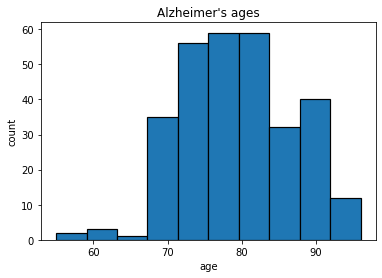

In [37]:
counts, bins = np.histogram(alz_bld_top100_xboost['AGE'].astype(float).astype(int))
plt.hist(bins[:-1], bins, weights=counts,edgecolor='black', linewidth=1.2)
plt.xlabel('age')
plt.ylabel('count')
plt.title("Alzheimer's ages")

Text(0.5, 1.0, "Parkinson's ages")

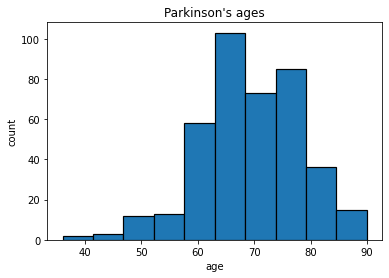

In [38]:
counts, bins = np.histogram(park_bld_top100_xboost['AGE'].astype(float).astype(int))
plt.hist(bins[:-1], bins, weights=counts,edgecolor='black', linewidth=1.2)
plt.xlabel('age')
plt.ylabel('count')
plt.title("Parkinson's ages")

# Alzheimer's fitting a linear model



In [39]:
alz_bld_top100_xboost_no_na = alz_bld_top100_xboost.dropna(axis='columns')
alz_bld_top100_xboost_no_na

sample_id,AGE,cg01074797,cg06784991,cg07181952,cg07418114,cg23606718,cg07553761,cg01552919,cg26113593,cg06540876,...,cg22193924,cg00535618,cg05308819,cg09809672,cg10221746,cg18343474,cg18933331,cg25410668,cg06639320,cg03607117
GSM1069225,81.0,0.525,0.406,0.617,0.632,0.226,0.391,0.794,0.755,0.593,...,0.830,0.712,0.491,0.431,0.548,0.144,0.391,0.635,0.530,0.081
GSM1069226,88.0,0.582,0.336,0.612,0.693,0.220,0.367,0.736,0.821,0.555,...,0.742,0.717,0.422,0.356,0.575,0.156,0.360,0.746,0.606,0.117
GSM1069227,91.0,0.558,0.310,0.635,0.694,0.232,0.329,0.807,0.807,0.563,...,0.847,0.671,0.461,0.414,0.561,0.154,0.355,0.785,0.538,0.090
GSM1069228,87.0,0.583,0.378,0.678,0.681,0.356,0.343,0.854,0.813,0.452,...,0.814,0.710,0.484,0.502,0.709,0.143,0.445,0.688,0.559,0.052
GSM1069229,89.0,0.519,0.270,0.540,0.596,0.179,0.392,0.745,0.754,0.481,...,0.816,0.738,0.402,0.287,0.473,0.327,0.275,0.691,0.587,0.094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1870611,75.9,0.519,0.259,0.610,0.684,0.219,0.311,0.781,0.769,0.583,...,0.814,0.727,0.437,0.337,0.602,0.140,0.434,0.696,0.513,0.114
GSM3035793,80.0,0.465,0.299,0.590,0.670,0.196,0.350,0.765,0.706,0.439,...,0.700,0.671,0.443,0.400,0.600,0.193,0.335,0.616,0.549,0.073
GSM1870291,75.9,0.519,0.259,0.610,0.684,0.219,0.311,0.781,0.769,0.583,...,0.814,0.727,0.437,0.337,0.602,0.140,0.434,0.696,0.513,0.114
GSM1299778,70.0,0.398,0.262,0.671,0.668,0.221,0.383,0.792,0.750,0.585,...,0.787,0.756,0.506,0.356,0.603,0.099,0.355,0.697,0.527,0.225


In [183]:
X = alz_bld_top_xboost.iloc[:, 1:].to_numpy()
y = alz_bld_top_xboost[['AGE']].astype(float).astype(int)

In [180]:
X.shape

(299, 1100)